In [310]:
import os.path 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from statistics import pstdev
from scipy.fft import fftshift, ifft, fftfreq
import numpy as np
from scipy.signal.windows import tukey
import math
from scipy.interpolate import interp1d
from time import time as time
from time import strftime
from datetime import date
from scipy.signal import ShortTimeFFT
from scipy.signal import find_peaks, peak_widths
from scipy.stats import norm
from IPython.display import display, Latex
import re 
from scipy import optimize
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit
from scipy.signal import hilbert
import lmfit

from scipy.signal.windows import tukey

plt.rcParams.update({'font.size':13})

## Useful Functions

In [311]:
def FWHM(x,y):

    peak_centre =[]
    unit_widths=[]
    full_width_half_max=[]
    lefts_unit =[]
    rights_unit=[]
    lefts =[]
    rights=[]
    heights=[]
    
    dx = x[1]-x[0]

    #print(dx)

    
    
    

    peak,peak_heights = find_peaks(y,distance =1,prominence= 0.2*np.max(y), height = 0.75)

    peak_y = peak_heights["peak_heights"]

    heights.append(peak_y)

    peak_centre.append(peak[0])

    widths =  peak_widths(y, peak_centre, rel_height =0.5)  

    #print(widths)
    
    unit_widths.append(widths[0])
    lefts_unit.append(widths[2])
    rights_unit.append(widths[3])

    for i in range(len(unit_widths)):

        fwhm = unit_widths[i] 
        #print(fwhm)
        left_pos = lefts_unit[i]    
        right_pos = rights_unit[i]   
        full_width_half_max.append(fwhm)
        lefts.append(left_pos)
        rights.append(right_pos)

   
    

    '''
    for i in range(len(full_width_half_max)):

        print('The peak has a FWHM of {0:.3f}fs with a LH crossing of {1:.3f}fs and a RH crossing of {2:.3f}fs'.format(float(full_width_half_max[i]), float(lefts[i]), float(rights[i])) ) 
    '''
    
    return full_width_half_max, lefts, rights, heights, dx, fwhm

def FWHM_2(x,y):
    peak =np.argmax(y)
    peak_val =y[peak]
    half_max = peak_val /2 
    print(peak_val)

    # Left side
    left_region = y[:peak]
    if np.any(left_region <= half_max):
        y1 = np.where(left_region <= half_max)[0][-1]
        y0 = y1 + 1
        # linear interpolation for crossing
        x_left = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    #else:
        #return np.nan
    
    # Right side
    right_region = y[peak:]
    if np.any(right_region <= half_max):
        y1 = np.where(right_region <= half_max)[0][0] + peak
        y0 = y1 - 1
        x_right = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    #else:
        #return np.nan
    print(x_left)
    fwhm = x_right -x_left
    return fwhm


## Load that FROG

In [312]:
data_75 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/181125/181125_75fs_FROG_1201_150_1d.txt'
data_25 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/181125/181125_25fs_FROG_1201_150_1d.txt'
data_TL = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/181125/181125_TL_FROG_1d.txt'

loaded_data_75 = np.loadtxt(data_75)
loaded_data_25 = np.loadtxt(data_25)

loaded_data_TL = np.loadtxt(data_TL)

time_75 = loaded_data_75[:,0]
amp_75 = loaded_data_75[:,1]
#amp_75=amp_75/np.max(amp_75)
time_25 = loaded_data_25[:,0]
amp_25 = loaded_data_25[:,1]
#amp_25=(amp_25/np.max(amp_25))

time_TL = loaded_data_TL[:,0]
amp_TL = loaded_data_TL[:,1]
#amp_TL=amp_TL/np.max(amp_TL)

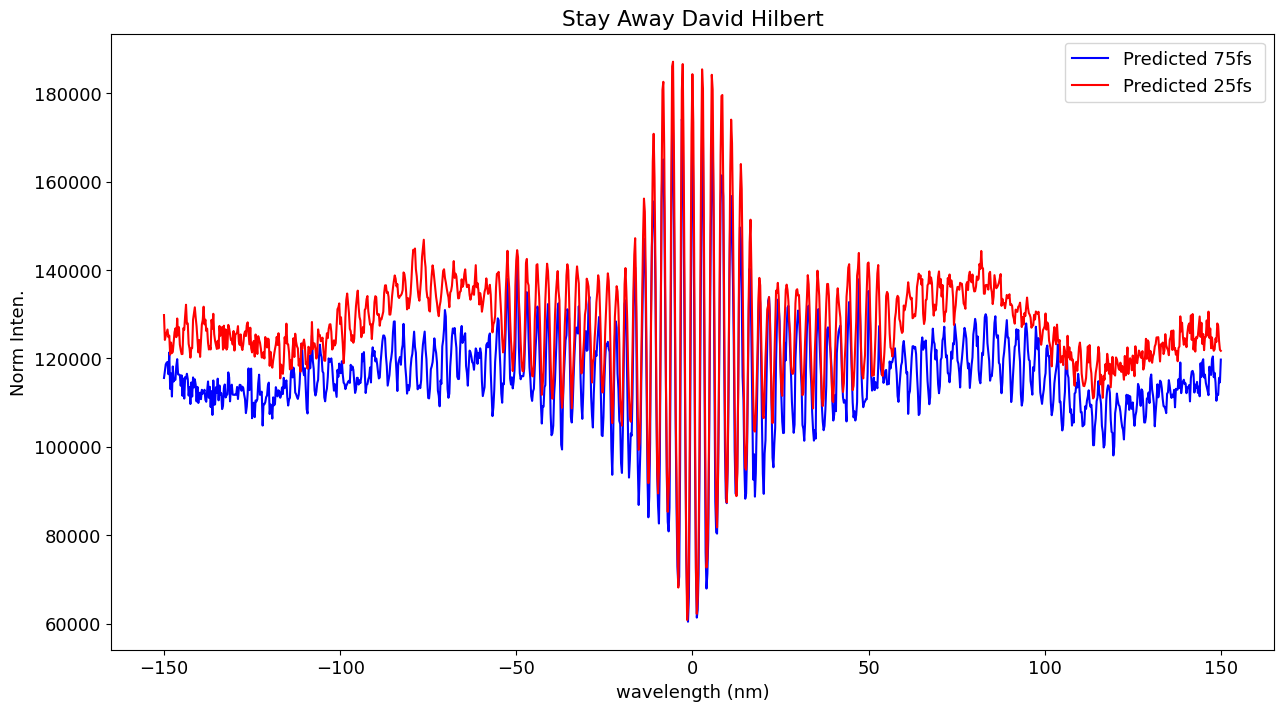

In [313]:
plt.figure(figsize=(15,8))
plt.plot(waves_75, amp_75, color ='blue', label ='Predicted 75fs')
plt.plot(time_25, amp_25, color ='red',label ='Predicted 25fs ')

#plt.plot(time_TL, amp_TL, color ='magenta', label = 'TL')
#plt.plot(phases,linear_func(phases,*params1), color='green', label ='Fit tau = {0:.3f}GDD + {1:.3f}'.format(params1[0],params1[1]))
plt.xlabel("wavelength (nm)")
plt.ylabel("Norm Inten.")
plt.title("Stay Away David Hilbert")
plt.legend()
#plt.xlim(-200,400)


plt.show()

In [314]:

analytic_signal = hilbert(amp_TL)
envelope = np.abs(analytic_signal)



N = len(amp_TL)
center = N // 2
halfwidth = 100  # 100 total points = 50 on each side

start = center - halfwidth
end = center + halfwidth
signal_center = amp_TL[start:end]
envelope_center = envelope[start:end]

# if you have time array too:
time_center = time_TL[start:end]

#peaks, _ = find_peaks(amp_TL)
#central_peak_idx = peaks[np.argmin(np.abs(peaks - len(amp_TL)//2))]



def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

def sinc(x,A,B,C):
    return A*((np.sin(B*x))/x)+C

A0 = 100*np.max(envelope_center)
mu0 = time_center[np.argmax(envelope_center)]
sigma0 = (time_center[-1] - time_center[0]) / 10
offset0 = np.min(envelope_center)
p0 = [A0, mu0, sigma0, offset0]

#p0 = [np.max(envelope_center), 0, 10, np.min(envelope_center)] 
#p0 = [np.max(envelope_center), 1, 1, np.max(envelope_center)] 
p1=[2e6,4,1.1e6]

params,params_covariance = curve_fit(gaussian, time_TL, envelope, p0=p0,maxfev =1000, method ='dogbox')
params1, params_covariance1 = curve_fit(sinc,time_center, envelope_center, p0 =p1, maxfev =2000)
avg_baseline = np.mean(amp_TL[:200])
print(avg_baseline)

half_height = (np.max(amp_TL)-avg_baseline)/2


1178253.033


/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_17583/2616368631.py:27: RuntimeWarning: invalid value encountered in divide
  return A*((np.sin(B*x))/x)+C
/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_17583/2616368631.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  params1, params_covariance1 = curve_fit(sinc,time_center, envelope_center, p0 =p1, maxfev =2000)


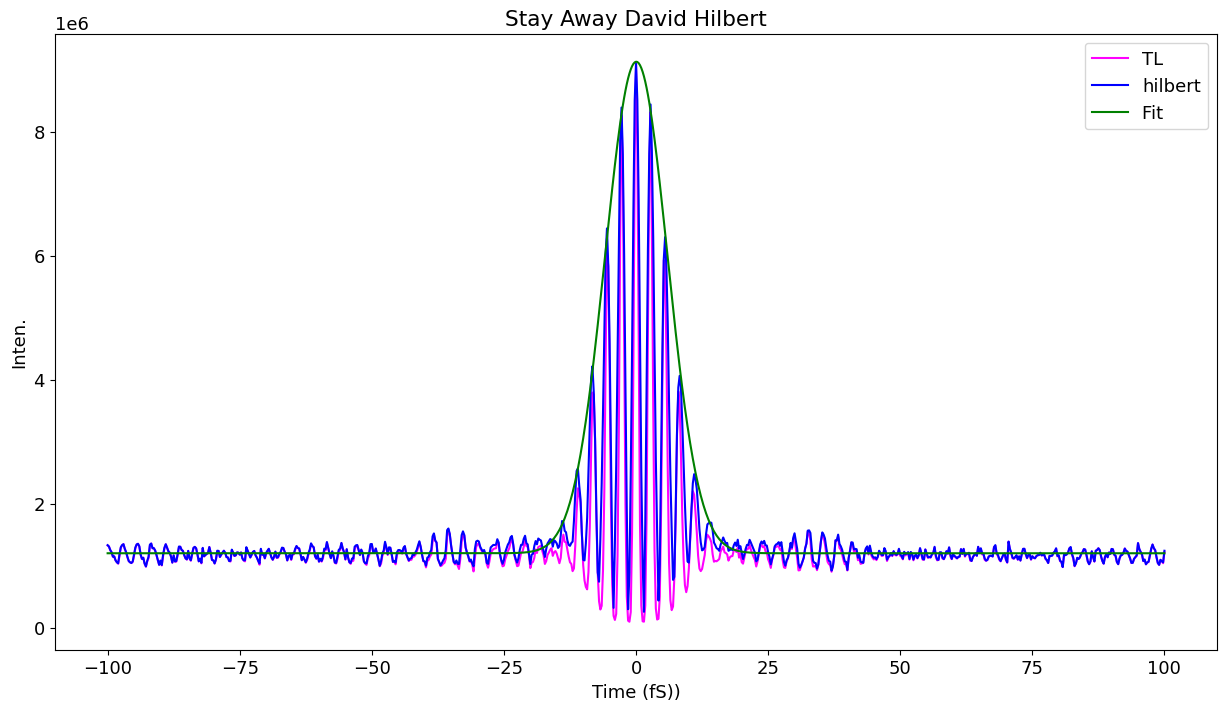

[2.0e+06 4.0e+00 1.1e+06]


In [315]:
plt.figure(figsize=(15,8))
#plt.plot(waves_75, amp_75, color ='blue', label ='Predicted 75fs')
#plt.plot(waves_25, amp_25, color ='red',label ='Predicted 25fs ')

plt.plot(time_TL, amp_TL, color ='magenta', label = 'TL')
plt.plot(time_TL, envelope, color ='blue', label = 'hilbert')
plt.plot(time_TL,gaussian(time_TL,(2.135*params[0]),params[1],params[2],params[3]), color='green', label ='Fit ')
#plt.plot(time_center,sinc(time_center,(params1[0]),params1[1],params1[2]), color='red', label ='Sinc ')
#plt.plot(time_center, envelope_center, color ='red')
#plt.axhline(half_height)
#plt.axhline(0.5*np.max(amp_TL),color= 'red')
#plt.axvline(-8.1)
#plt.axvline(8.1)
plt.xlabel("Time (fS))")
plt.ylabel("Inten.")
plt.title("Stay Away David Hilbert")
plt.legend()
#plt.xlim(-200,400)


plt.show()

print(params1)

In [316]:
peaks,peak_heights = find_peaks(amp_TL,distance =10,prominence= 1e4)

print(peaks)
print(len(peaks))



[ 12  23  33  44  55  66  77  94 105 122 133 143 154 166 177 189 200 210
 225 236 247 258 269 281 295 306 316 328 345 356 367 378 389 400 411 421
 432 443 454 466 486 497 507 520 530 541 553 563 577 588 599 615 626 637
 648 659 672 682 693 706 718 729 739 750 760 770 780 791]
68


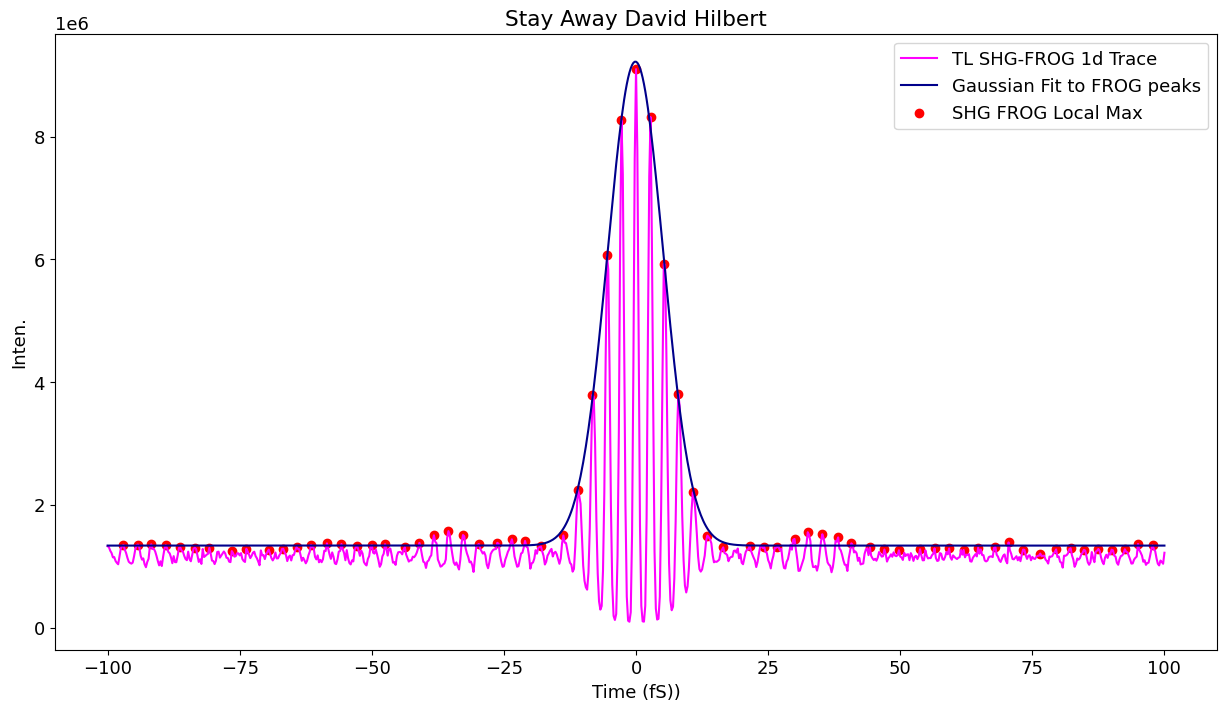

1.0
-7.103521049826271
The estimated TL temporal width based on the above manipulation is 6.984fs


In [317]:

params2,params_covariance2 = curve_fit(gaussian, time_TL[peaks], amp_TL[peaks], p0=p0,maxfev =1000)


plt.figure(figsize=(15,8))
#plt.plot(waves_75, amp_75, color ='blue', label ='Predicted 75fs')
#plt.plot(waves_25, amp_25, color ='red',label ='Predicted 25fs ')

plt.plot(time_TL, amp_TL, color ='magenta', label = 'TL SHG-FROG 1d Trace')
plt.plot(time_TL,gaussian(time_TL,(params2[0]),params2[1],params2[2],params2[3]), color='darkblue', label ='Gaussian Fit to FROG peaks')
#plt.plot(time_TL,gaussian(time_TL,(2.135*params[0]),params[1],params[2],params[3]), color='green', label ='Fit ')
plt.scatter(time_TL[peaks], amp_TL[peaks], color='red', label = 'SHG FROG Local Max')
plt.xlabel("Time (fS))")
plt.ylabel("Inten.")
plt.title("Stay Away David Hilbert")
plt.legend()
#plt.xlim(-200,400)


plt.show()

envelope_fit = (gaussian(time_TL,(params2[0]),params2[1],params2[2],params2[3]))/np.max(gaussian(time_TL,(params2[0]),params2[1],params2[2],params2[3]))
time_fit = time_TL[peaks]

fwhm = FWHM_2(time_TL,envelope_fit)


print('The estimated TL temporal width based on the above manipulation is {0:.3f}fs'.format(fwhm/2))

In [318]:
peaks_25,peak_heights_25 = find_peaks(amp_25,distance =10,prominence= 1e4)

print(peaks_25)
print(len(peaks_25))


[  25   35   45  139  208  220  285  295  305  329  380  390  401  412
  424  435  447  458  469  480  493  504  514  524  535  545  556  567
  578  589  600  611  622  634  644  655  666  676  687  697  707  719
  731  742  754  765  778  789  800  811  821  857  869  880  892  928
 1061]
57


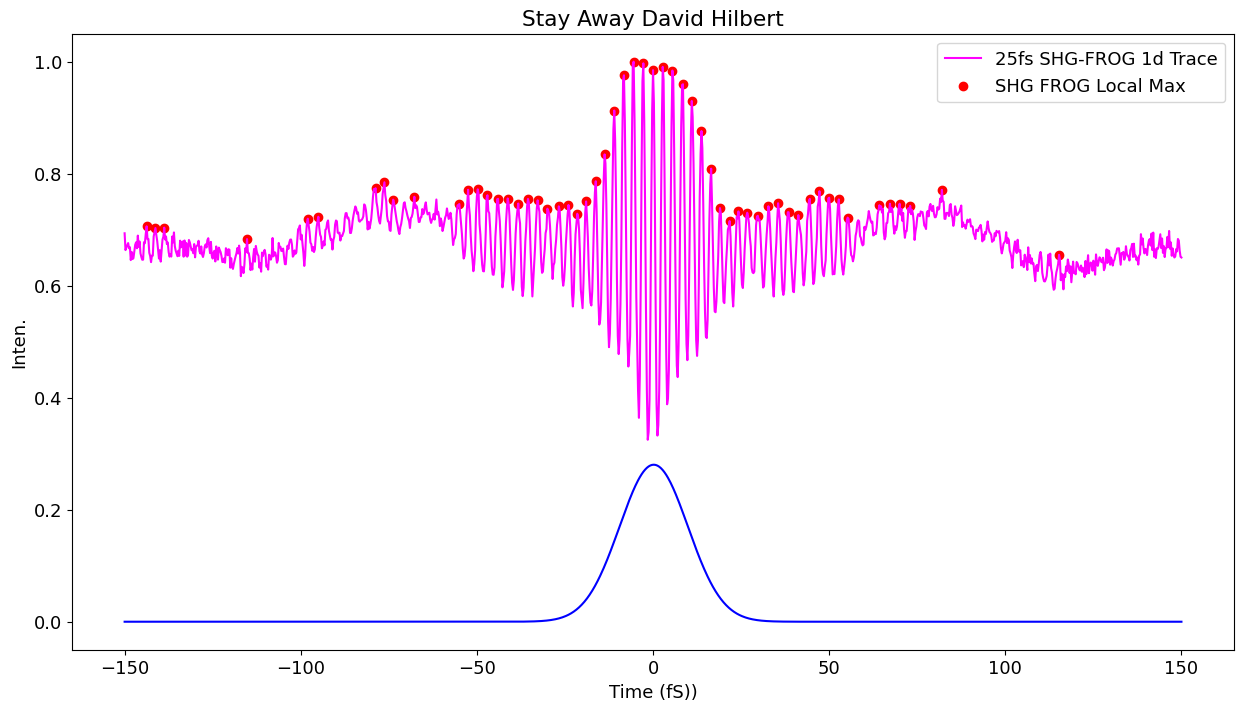

0.2803904716504352
-11.216996506585257
The estimated TL temporal width based on the above manipulation is 11.415fs


In [319]:
params3,params_covariance3 = curve_fit(gaussian, time_25[peaks_25], amp_25[peaks_25], p0=p0,maxfev =1000)

envelope_fit_25 = (gaussian(time_25,(params3[0]),params3[1],params3[2],params3[3]))/np.max((gaussian(time_25,(params3[0]),params3[1],params3[2],params3[3])))
time_fit_25 = time_25[peaks_25]

envelope_fit_25 = envelope_fit_25 - envelope_fit_25[0]

plt.figure(figsize=(15,8))
#plt.plot(waves_75, amp_75, color ='blue', label ='Predicted 75fs')
#plt.plot(waves_25, amp_25, color ='red',label ='Predicted 25fs ')

plt.plot(time_25, amp_25/np.max(amp_25), color ='magenta', label = '25fs SHG-FROG 1d Trace')
#plt.plot(time_25,gaussian(time_25,(params3[0]),params3[1],params3[2],params3[3]), color='darkblue', label ='Gaussian Fit to FROG peaks')
plt.plot(time_25, envelope_fit_25, color ='blue')
plt.scatter(time_25[peaks_25], amp_25[peaks_25]/np.max(amp_25[peaks_25]), color='red', label = 'SHG FROG Local Max')
plt.xlabel("Time (fS))")
plt.ylabel("Inten.")
plt.title("Stay Away David Hilbert")
plt.legend()
#plt.xlim(-200,400)


plt.show()




fwhm_25 = FWHM_2(time_25,envelope_fit_25)


print('The estimated TL temporal width based on the above manipulation is {0:.3f}fs'.format(fwhm_25/2))

In [320]:
peaks_75,peak_heights_75 = find_peaks(amp_75,distance =10,prominence= 1e4)

print(peaks_75)
print(len(peaks_75))


[  96  156  168  249  262  272  284  296  307  319  338  379  390  401
  412  424  436  448  458  471  483  494  513  524  535  545  556  567
  577  588  600  611  623  633  644  654  665  676  687  697  709  720
  732  743  754  768  778  789  800  812  840  851  861  873  886  898
  909  921  933  944  957  968  979  990 1003 1015 1025 1038 1061 1072
 1082 1121 1191]
73


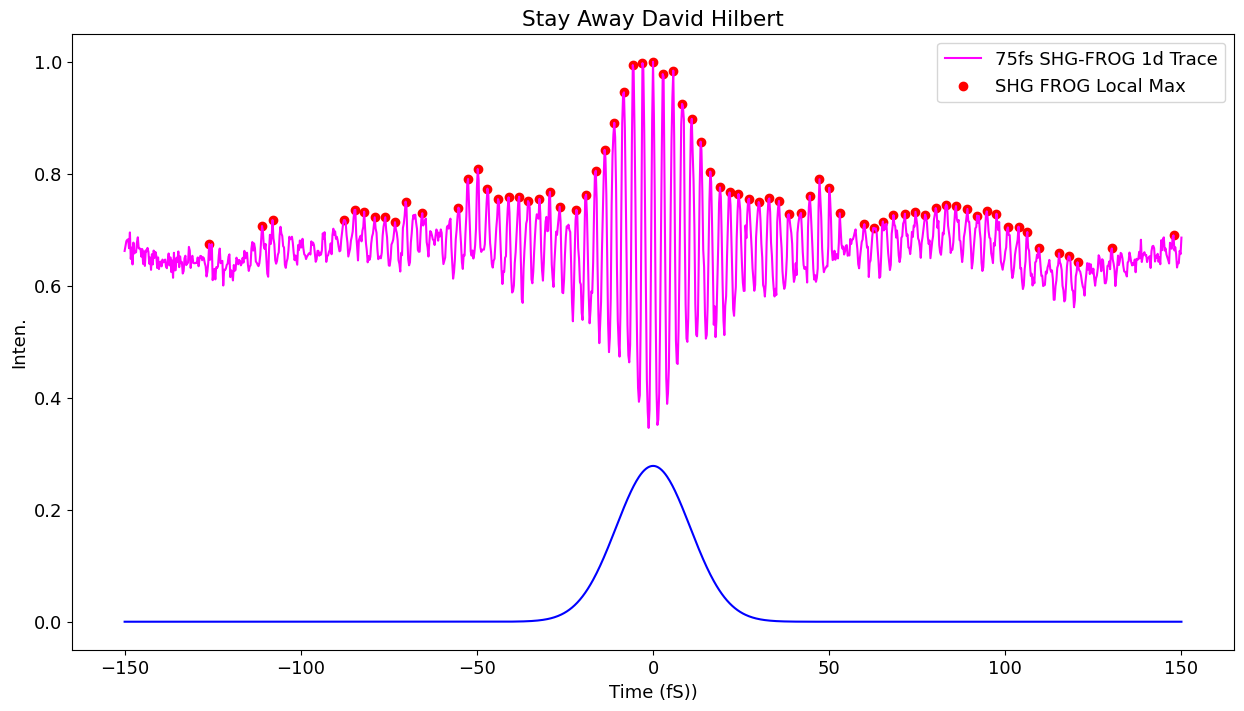

0.27826484283591746
-12.348660848816406
The estimated TL temporal width based on the above manipulation is 12.374fs


In [321]:
params4,params_covariance4 = curve_fit(gaussian, time_75[peaks_75], amp_75[peaks_75], p0=p0,maxfev =1000)

envelope_fit_75 = (gaussian(time_75,(params4[0]),params4[1],params4[2],params4[3]))/np.max((gaussian(time_75,(params4[0]),params4[1],params4[2],params4[3])))
time_fit_75 = time_75[peaks_75]

envelope_fit_75 = envelope_fit_75 - envelope_fit_75[0]

plt.figure(figsize=(15,8))
#plt.plot(waves_75, amp_75, color ='blue', label ='Predicted 75fs')
#plt.plot(waves_25, amp_25, color ='red',label ='Predicted 25fs ')

plt.plot(time_75, amp_75/np.max(amp_75), color ='magenta', label = '75fs SHG-FROG 1d Trace')
#plt.plot(time_25,gaussian(time_25,(params3[0]),params3[1],params3[2],params3[3]), color='darkblue', label ='Gaussian Fit to FROG peaks')
plt.plot(time_75, envelope_fit_75, color ='blue')
plt.scatter(time_75[peaks_75], amp_75[peaks_75]/np.max(amp_75[peaks_75]), color='red', label = 'SHG FROG Local Max')
plt.xlabel("Time (fS))")
plt.ylabel("Inten.")
plt.title("Stay Away David Hilbert")
plt.legend()
#plt.xlim(-200,400)


plt.show()




fwhm_75 = FWHM_2(time_75,envelope_fit_75)


print('The estimated TL temporal width based on the above manipulation is {0:.3f}fs'.format(fwhm_75/2))